# Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import KeyedVectors
import tensorflow_hub as hub

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


# Data Loading and Data Analysis

In [2]:
df = pd.read_csv(r'Data\data_after_preprocessing.csv')
df.head()

,id,sentence,price,quality,environment,service,other
0,1,i ordered egg soft noodles from here they did ...,NaN,Negative,NaN,Negative,NaN
1,2,ice cream was good but it is totally got melt ...,NaN,Positive,NaN,Negative,NaN
2,2,he mentioned it as delivered as soon as he pic...,NaN,NaN,NaN,Negative,NaN
3,2,he took nearly forty five minutes to come,NaN,NaN,NaN,Negative,NaN
4,3,food was not good its from yesterdays food wit...,NaN,Negative,NaN,Negative,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5288 entries, 0 to 5287
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5288 non-null   int64 
 1   sentence     5288 non-null   object
 2   price        207 non-null    object
 3   quality      2244 non-null   object
 4   environment  590 non-null    object
 5   service      1187 non-null   object
 6   other        535 non-null    object
dtypes: int64(1), object(6)
memory usage: 289.3+ KB


### Prepare data
Đối với đầu vào X, ta sử dụng các câu mà có ít nhất một khía cạnh được nhận diện, để mô hình có thể dự đoán cảm xúc đối với khía cạnh đó.

In [4]:
aspects = ['price', 'quality', 'environment', 'service', 'other']

records = []
for idx, row in df.iterrows():
    for aspect in aspects:
        if pd.notna(row[aspect]):
            records.append({
                'sentence': row['sentence'] + ' [ASP] ' + aspect,
                'sentiment': row[aspect]
            })
df_sentiment = pd.DataFrame(records)
df_sentiment.head()

,sentence,sentiment
0,i ordered egg soft noodles from here they did ...,Negative
1,i ordered egg soft noodles from here they did ...,Negative
2,ice cream was good but it is totally got melt ...,Positive
3,ice cream was good but it is totally got melt ...,Negative
4,he mentioned it as delivered as soon as he pic...,Negative


In [5]:
X = df_sentiment['sentence']
y = df_sentiment['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})
X

0       i ordered egg soft noodles from here they did ...
1       i ordered egg soft noodles from here they did ...
2       ice cream was good but it is totally got melt ...
3       ice cream was good but it is totally got melt ...
4       he mentioned it as delivered as soon as he pic...
                              ...                        
4758    my overall experience was amazing chef but mes...
4759    i would like to mention that every staff membe...
4760                loved their hospitality [ASP] service
4761    i would definitely recommend this place to hav...
4762    i would definitely recommend this place to hav...
Name: sentence, Length: 4763, dtype: object

Dữ liệu đầu vào của hai bài toán Aspect Recognition và ABSA có sự khác biệt:

- Aspect Recognition sử dụng 5.288 dòng dữ liệu, mỗi dòng là một câu bình luận hoàn chỉnh nhằm xác định các khía cạnh được đề cập trong câu.

- ABSA (Aspect-Based Sentiment Analysis) sử dụng 4.761 dòng, trong đó mỗi dòng là sự kết hợp giữa câu bình luận và một khía cạnh cụ thể, phục vụ cho việc dự đoán cảm xúc tương ứng với khía cạnh đó.

### Data Analysis

In [6]:
df_sentiment['sentiment'].value_counts()

sentiment
Negative    2471
Positive    2018
Neutral      274
Name: count, dtype: int64

<Axes: ylabel='count'>

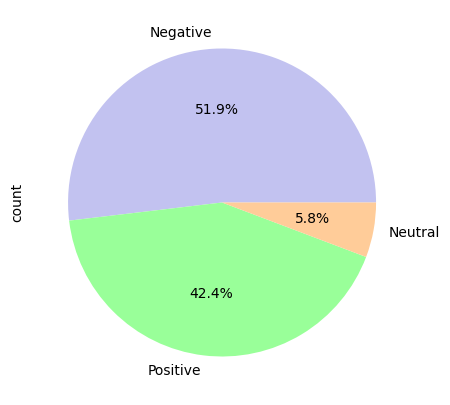

In [ ]:
colors = ['#99FF99', '#66B3FF', '#FFCC99']
df_sentiment['sentiment'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(5, 5),
    colors=colors 
)

In [8]:
records = []
for idx, row in df.iterrows():
    for aspect in aspects:
        if pd.notna(row[aspect]):
            records.append({
                'sentence': row['sentence'],
                'aspect': aspect,
                'sentiment': row[aspect]
            })
aspect_sentiment = pd.DataFrame(records)

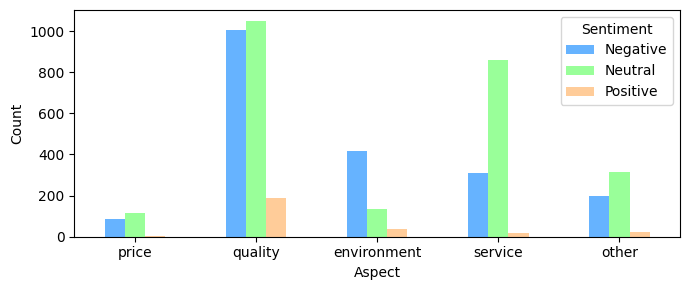

In [9]:
sentiment_counts = aspect_sentiment.groupby(['aspect', 'sentiment']).size().reset_index(name='count')

pivot_df = sentiment_counts.pivot(index='aspect', columns='sentiment', values='count').fillna(0).astype(int)

sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['#66B3FF', '#99FF99', '#FFCC99'] 
labels = ['Negative', 'Neutral', 'Positive']

# Sắp xếp aspect theo aspect_cols
pivot_df = pivot_df.reindex(aspects)
pivot_df = pivot_df[sentiments]
pivot_df.plot(kind='bar', figsize=(7, 3), color=colors)

plt.xlabel("Aspect")
plt.ylabel("Count")
plt.legend(labels, title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Embedding

### TF-IDF

In [10]:
keep_words = [
    # Negative words
    'not', 'no', 'none', 'never', 'nothing', 'nobody', 'nowhere', 'neither', 'without',
    'cannot', 'cant', 'couldnt', 'hasnt', 'nor',

    # Adjective/Adverb
    'well', 'interest',

    # Numerous
    'one', 'two', 'three', 'four', 'five', 'six', 'eight', 'nine', 'ten',
    'eleven', 'twelve', 'fifteen', 'twenty', 'forty', 'fifty', 'sixty',
    'hundred'
]
custom_stopwords = list(ENGLISH_STOP_WORDS.difference(keep_words))

In [11]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words=custom_stopwords)

def fit_tfidf(X_train_text):
    vectorizer.fit(X_train_text)

def transform_tfidf(X_text):
    return vectorizer.transform(X_text).toarray()

### USE

In [12]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
use_model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed_USE(input):
    return np.array(use_model(input))

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


### FastText

In [13]:
fastText_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False)

In [14]:
def sentence_to_vector(sentence):
    words = sentence.split()
    filtered_words = [w for w in words if w not in custom_stopwords]
    word_vectors = [fastText_model[w] for w in filtered_words if w in fastText_model]
    if not word_vectors:
        return np.zeros(fastText_model.vector_size)
    return np.mean(word_vectors, axis=0)

In [15]:
def embed_fastText(input):
    vectors = input.apply(sentence_to_vector)
    return np.vstack(vectors.values)

# Define models

In [16]:
models = {
      "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
      "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
      "SVC": LinearSVC(max_iter=1000, random_state=42),
      "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0)
}

In [17]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    recall, precision, f1 = (
        recall_score(y_test, y_pred, average='weighted', zero_division=0),
        precision_score(y_test, y_pred, average='weighted', zero_division=0),
        f1_score(y_test, y_pred, average='weighted', zero_division=0)
    )
    return recall, precision, f1, y_test, y_pred

In [18]:
def experiment_with_kfold(X, y, embedding, model):
  kf = KFold(n_splits=5, shuffle=True)
  recalls, precisions, f1s = [], [], []

  for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    if embedding == 'TF-IDF':
      fit_tfidf(X_train)
      X_train = transform_tfidf(X_train)
      X_test = transform_tfidf(X_test)

    if embedding == 'USE':
      X_train, X_test = embed_USE(X_train), embed_USE(X_test)

    if embedding == 'FAST_TEXT':
      X_train, X_test = embed_fastText(X_train), embed_fastText(X_test)

    recall, precision, f1, _, _ = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1)

  return recalls, precisions, f1s

## Experiment

In [55]:
base_model = models['Logistic Regression']
Tfidf = experiment_with_kfold(X, y, 'TF-IDF', base_model)
use = experiment_with_kfold(X, y, 'USE', base_model)
fastText = experiment_with_kfold(X, y, 'FAST_TEXT', base_model)

In [56]:
results_Tfidf = (pd.DataFrame(Tfidf)).T
results_Tfidf.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
results_Tfidf.columns = ['Recall', 'Precision', 'F1 Score']
results_Tfidf.style.highlight_max(axis=0, color='lightgreen')

,Recall,Precision,F1 Score
Fold 1,0.783841,0.807026,0.793954
Fold 2,0.761805,0.789433,0.773091
Fold 3,0.767051,0.811971,0.785418
Fold 4,0.765756,0.802742,0.780748
Fold 5,0.775210,0.805140,0.787514


In [57]:
results_USE = (pd.DataFrame(use)).T
results_USE.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
results_USE.columns = ['Recall', 'Precision', 'F1 Score']
results_USE.style.highlight_max(axis=0, color='lightgreen')

,Recall,Precision,F1 Score
Fold 1,0.761805,0.838906,0.791282
Fold 2,0.763903,0.811423,0.782737
Fold 3,0.756558,0.827999,0.785230
Fold 4,0.776261,0.841048,0.801467
Fold 5,0.783613,0.846928,0.808922


In [58]:
results_FAST_TEXT = (pd.DataFrame(fastText)).T
results_FAST_TEXT.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
results_FAST_TEXT.columns = ['Recall', 'Precision', 'F1 Score']
results_FAST_TEXT.style.highlight_max(axis=0, color='lightgreen')

,Recall,Precision,F1 Score
Fold 1,0.745016,0.823129,0.775526
Fold 2,0.726128,0.808436,0.757561
Fold 3,0.743966,0.792794,0.762923
Fold 4,0.760504,0.816635,0.782370
Fold 5,0.746849,0.804044,0.770186


**Ở phần này, ta cần chú trọng kết quả Precision để tránh việc dự đoán sai nhãn**

In [59]:
recall_tfidf, precision_tfidf, f1_tfidf = Tfidf
recall_use, precision_use, f1_use = use
recall_fastText, precision_fastText, f1_fastText = fastText

f_stat, p_val = stats.f_oneway(precision_tfidf, precision_use, precision_fastText)
print(f"F-statistic: {f_stat:.5f}")
print(f"p-value: {p_val:.5f}")

F-statistic: 9.42218
p-value: 0.00347


Vì p-value < 0.05, ta có thể kết luận rằng sự khác biệt này là có ý nghĩa thống kê.

Tiếp điến ta tiến hành kiểm nghiệm giữa từng cặp phương pháp embedding

In [60]:
scores = precision_tfidf + precision_use + precision_fastText
methods = ['TF-IDF'] * len(precision_tfidf) + ['USE'] * len(precision_use) + ['FAST_TEXT'] * len(precision_fastText)

tukey_df = pd.DataFrame({'Precision': scores, 'method': methods})

tukey = pairwise_tukeyhsd(endog=tukey_df['Precision'], groups=tukey_df['method'], alpha=0.05)
print("\nTukey HSD kết quả:")
print(tukey)

mean_scores = tukey_df.groupby('method')['Precision'].mean().sort_values(ascending=False)
print("\nPhương pháp có precision trung bình cao nhất:", mean_scores.index[0])
print(mean_scores)


Tukey HSD kết quả:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
  group1  group2 meandiff p-adj  lower  upper  reject
-----------------------------------------------------
FAST_TEXT TF-IDF  -0.0057  0.72 -0.0253 0.0138  False
FAST_TEXT    USE   0.0243 0.016  0.0047 0.0438   True
   TF-IDF    USE     0.03 0.004  0.0104 0.0496   True
-----------------------------------------------------

Phương pháp có precision trung bình cao nhất: USE
method
USE          0.833261
FAST_TEXT    0.809007
TF-IDF       0.803263
Name: Precision, dtype: float64


Kết quả kiểm định hậu nghiệm Tukey HSD cho thấy sự khác biệt giữa USE và hai phương pháp embedding còn lại có ý nghĩa thống kê.

-  USE và TF-IDF: p = 0.004
-  USE và FastText: p = 0.016

Trong khi đó, không có sự khác biệt rõ rệt giữa fastText và TF-IDF (p = 0.72). 

Với kết quả precision trung bình đạt 0.8333, **USE** được xem là phương pháp embedding hiệu quả nhất về mặt precision cho bài toán hiện tại.

## Modeling
USE

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
X_train, X_test = embed_USE(X_train), embed_USE(X_test)

In [62]:
results = []
for model_name, model in models.items():
    recall, precision, f1, _, _ = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    results.append({'Model': model_name,
                    'Recall': recall,
                    'Precision': precision,
                    'F1 Score': f1})

results_df = pd.DataFrame(results)
results_df.style.highlight_max(subset=['Recall', 'Precision', 'F1 Score'], axis=0, color='lightgreen')

,Model,Recall,Precision,F1 Score
0,Logistic Regression,0.774397,0.860294,0.808541
1,Random Forest,0.835257,0.813208,0.816426
2,SVC,0.852046,0.841046,0.835621
3,XGBoost,0.842602,0.827158,0.830181


### Conclusion
Từ kết quả trên ta thấy mô hình Logistic Regression cho kết quả tốt nhất nên ta lựa chọn mô hình này cho phần Sentiment Classification

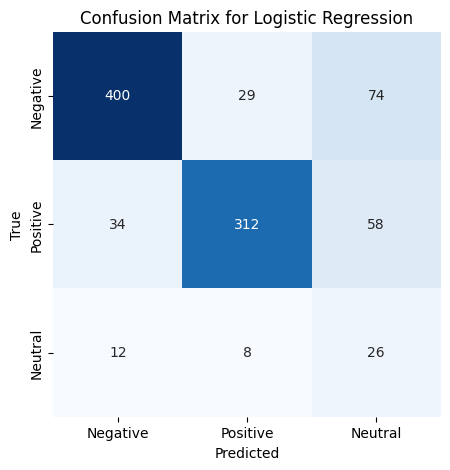

In [63]:
_, _, _, y_test, y_pred = train_and_evaluate(models['Logistic Regression'], X_train, y_train, X_test, y_test)

cm = confusion_matrix(y_test, y_pred)
sentiment = ['Negative', 'Positive', 'Neutral']
cm_df = pd.DataFrame(cm, index=sentiment, columns=sentiment)

plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()